https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [5]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

In [6]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [7]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [8]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

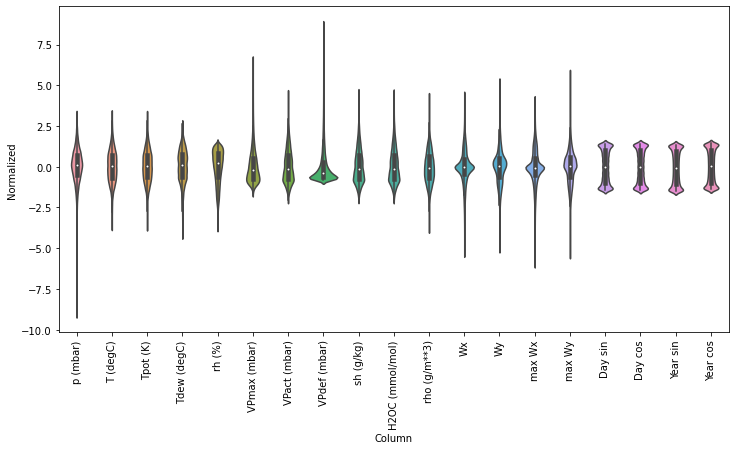

In [11]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [12]:
input_width = 24
label_width = 1
shift = 24

train_df=train_df
val_df=val_df
test_df=test_df
label_columns=['T (degC)']

In [13]:
if label_columns is not None:
    label_columns_indices = {name: i for i, name in
                                enumerate(label_columns)}
column_indices = {name: i for i, name in
                    enumerate(train_df.columns)}

column_indices


{'p (mbar)': 0,
 'T (degC)': 1,
 'Tpot (K)': 2,
 'Tdew (degC)': 3,
 'rh (%)': 4,
 'VPmax (mbar)': 5,
 'VPact (mbar)': 6,
 'VPdef (mbar)': 7,
 'sh (g/kg)': 8,
 'H2OC (mmol/mol)': 9,
 'rho (g/m**3)': 10,
 'Wx': 11,
 'Wy': 12,
 'max Wx': 13,
 'max Wy': 14,
 'Day sin': 15,
 'Day cos': 16,
 'Year sin': 17,
 'Year cos': 18}

In [14]:
total_window_size = input_width + shift

In [15]:
input_slice = slice(0, input_width)
input_indices = np.arange(total_window_size)[input_slice]

label_start = total_window_size - label_width
labels_slice = slice(label_start, None)
label_indices = np.arange(total_window_size)[labels_slice]

In [16]:
label_indices

array([47])

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [18]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [20]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

2022-10-07 22:53:05.264249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
train_df[100:100+w2.total_window_size]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
605,-0.371962,-1.256877,-1.222380,-1.154516,0.742600,-1.039035,-1.099495,-0.699095,-1.094449,-1.095378,1.117876,-0.008101,-1.858711,-0.012834,-1.793552,1.366133,0.366112,0.041125,1.423813
611,-0.323755,-1.255721,-1.225819,-1.158819,0.724479,-1.037735,-1.101871,-0.694943,-1.098193,-1.097726,1.129351,0.236194,-0.925165,0.232757,-1.111988,1.414323,0.000102,0.042144,1.423731
617,-0.224929,-1.292695,-1.269373,-1.207584,0.718439,-1.054630,-1.130386,-0.697019,-1.124398,-1.128242,1.193076,0.929816,0.199257,1.226761,0.201768,1.366133,-0.365907,0.043164,1.423647
623,-0.118873,-1.366641,-1.351897,-1.286468,0.748640,-1.085820,-1.175536,-0.709473,-1.173064,-1.172842,1.296353,1.085074,0.252860,1.426828,0.273597,1.224850,-0.706974,0.044183,1.423563
629,-0.028484,-1.411702,-1.403474,-1.283599,0.917770,-1.105314,-1.173159,-0.740608,-1.169321,-1.172842,1.364716,-0.497435,0.112580,-1.159488,0.033991,1.000100,-0.999854,0.045203,1.423478
635,0.069136,-1.432499,-1.430982,-1.312284,0.905689,-1.113111,-1.189793,-0.738532,-1.188038,-1.189274,1.411838,1.543241,0.442288,1.777778,0.479760,0.707200,-1.224590,0.046222,1.423393
641,0.158320,-1.460229,-1.465367,-1.392602,0.772802,-1.124807,-1.232566,-0.719851,-1.229218,-1.233874,1.464819,2.736996,1.020389,2.755284,0.985252,0.366111,-1.365864,0.047241,1.423307


In [27]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-2.11187895]],

       [[-1.46022873]],

       [[-1.47871527]]])>

In [25]:
example_inputs[0]

<tf.Tensor: shape=(6, 19), dtype=float64, numpy=
array([[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
        -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
        -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
        -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
         2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
         3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
         1.42843408e+00],
       [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
        -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
        -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
        -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
         2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
         7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
         1.42842359e+00],
       [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
        -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
        -1.52722507e+00, -7.88347960e-01, -1.52870268e+00,
        -1.531